# Second Analysis

#### Clusters and topics

#### Using Spacy and K-Means to analyze the tokens and try to group the contained sentences in each review.

Good tutorials and other texts

- Tutorial: Text Classification in Python Using spaCy
https://www.dataquest.io/blog/tutorial-text-classification-in-python-using-spacy/

## Importing all needed packages

#### Command to install **spaCy** package: ***pip install spacy***

In [1]:
import pandas as pd
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import time
import spacy
from tqdm import tqdm 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import MDS, TSNE
from gensim.models import LdaModel, LdaMulticore
from gensim.corpora import Dictionary
from gensim.utils import simple_preprocess
import seaborn as sns
import re
from pprint import pprint

## Loading the sentences of the CSV file.

In [2]:
nlp = spacy.load('pt_core_news_lg') # https://spacy.io/models/pt#pt_core_news_lg

In [3]:
df = pd.read_csv( 
    './datasets/sentences.csv',
    encoding = 'UTF8',
    sep = ';');
df.head()

,book_id,review_id,review_rating,sentence
0,8595081530,RM0NBXMBSU4M3,4,Sabe todos aqueles livros que ensinam você a c...
1,8595081530,RM0NBXMBSU4M3,4,Ou daqueles que você termina a leitura sentind...
2,8595081530,RM0NBXMBSU4M3,4,"Você NÃO vai encontrar um setup milagroso, ou ..."
3,8595081530,RM0NBXMBSU4M3,4,Basicamente este livro conta verdades sobre o ...
4,8595081530,RM0NBXMBSU4M3,4,Mostra os detalhes de uma forma tão direta e b...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176751 entries, 0 to 176750
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   book_id        176751 non-null  int64 
 1   review_id      176751 non-null  object
 2   review_rating  176751 non-null  int64 
 3   sentence       176750 non-null  object
dtypes: int64(2), object(2)
memory usage: 5.4+ MB


In [5]:
df.iloc[0]['sentence']

'Sabe todos aqueles livros que ensinam você a criar uma agenda para controle de gastos contendo tudo que você gasta durante determinado período de tempo e que você nunca consegue terminar o tal método?'

In [6]:
doc = nlp( df.iloc[0]['sentence'] )
tokens = [token.text for token in doc]
print(tokens)

['Sabe', 'todos', 'aqueles', 'livros', 'que', 'ensinam', 'você', 'a', 'criar', 'uma', 'agenda', 'para', 'controle', 'de', 'gastos', 'contendo', 'tudo', 'que', 'você', 'gasta', 'durante', 'determinado', 'período', 'de', 'tempo', 'e', 'que', 'você', 'nunca', 'consegue', 'terminar', 'o', 'tal', 'método', '?']


In [7]:
tokens = [token.lemma_ for token in doc]
print(tokens)

['Sabe', 'todo', 'aquele', 'livro', 'que', 'ensinar', 'você', 'o', 'criar', 'umar', 'agendar', 'parir', 'controlo', 'de', 'gasto', 'conter', 'tudo', 'que', 'você', 'gasto', 'durante', 'determinar', 'período', 'de', 'tempo', 'e', 'que', 'você', 'nunca', 'conseguir', 'terminar', 'o', 'tal', 'método', '?']


## Analysis of top sentences

In [8]:
df['sentence'].value_counts()

                                                                                1116
Muito bom                                                                        584
Recomendo.                                                                       561
!                                                                                514
Muito bom!                                                                       459
                                                                                ... 
Muito bom, fácil a leitura e bem diferente dos filmes hehehehe                     1
O Senhor do anéis completo.                                                        1
Gostei tanto que comprei em seguida o box                                          1
História muito cativante e divertida de se ler.                                    1
A poesia de  Amanda  é visceral ,intensa e tão próxima de todas as mulheres.       1
Name: sentence, Length: 138605, dtype: int64

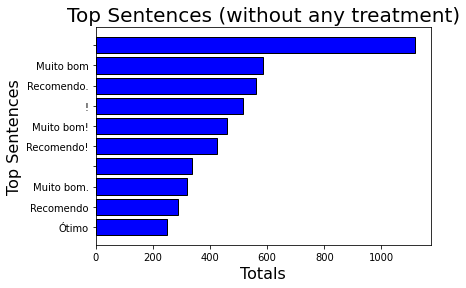

In [9]:
topSentencesLimit = 10
topSentences = df['sentence'].value_counts().index[ :topSentencesLimit ].tolist()[::-1] # [::-1] - Reverse the list
pos = np.arange( topSentencesLimit )
sentenceTotals = df['sentence'].value_counts().values[ :topSentencesLimit ].tolist()[::-1] # [::-1] - Reverse the list
 
plt.barh(
    pos,
    sentenceTotals,
    color='blue',
    edgecolor='black')
plt.yticks( pos, topSentences )
plt.xlabel( 'Totals', fontsize=16 )
plt.ylabel( 'Top Sentences', fontsize=16 )
plt.title( 'Top Sentences (without any treatment)', fontsize=20 )
plt.show()

In [10]:
def cleanSentence( sentence ):
    
    sentence = str( sentence )
    sentence = re.sub('[\,\.\!\?\%\'\(\)\,\-\_\“\”\●\♥\d\/\$\&\`\*\+\❞\°\–\…👏💪📸😁😍😘😚🙂🥰🥺❤🏻🏾💃💖😉😔😲✨💗💚🔝😊😕😻🧐]', '', sentence)
    sentence = re.sub('\bque\b|\bnos\b|\bde\b|\bem\b|\bcom\b|\bao\b|\btem\b|\bpessoas\b|\bmais\b', '', sentence)
    sentence = sentence.lower()
    
    return sentence

In [11]:
sentences = df['sentence'].tolist()
cleanedSentences = [cleanSentence( sentence ) for sentence in sentences]
dfTopSentences = df
dfTopSentences['sentence'] = cleanedSentences
dfTopSentences['sentence'].head()

0    sabe todos aqueles livros que ensinam você a c...
1    ou daqueles que você termina a leitura sentind...
2    você não vai encontrar um setup milagroso ou a...
3    basicamente este livro conta verdades sobre o ...
4    mostra os detalhes de uma forma tão direta e b...
Name: sentence, dtype: object

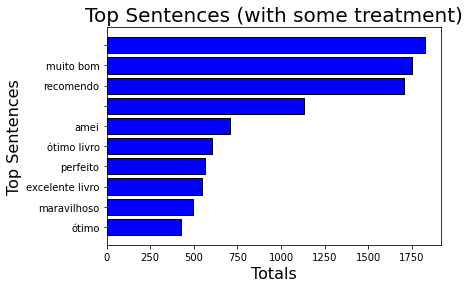

In [12]:
topSentencesLimit = 10
topSentences = dfTopSentences['sentence'].value_counts().index[ :topSentencesLimit ].tolist()[::-1] # [::-1] - Reverse the list
pos = np.arange( topSentencesLimit )
sentenceTotals = dfTopSentences['sentence'].value_counts().values[ :topSentencesLimit ].tolist()[::-1] # [::-1] - Reverse the list
 
plt.barh(
    pos,
    sentenceTotals,
    color='blue',
    edgecolor='black')
plt.yticks( pos, topSentences )
plt.xlabel( 'Totals', fontsize=16 )
plt.ylabel( 'Top Sentences', fontsize=16 )
plt.title( 'Top Sentences (with some treatment)', fontsize=20 )
plt.show()

### Repeated Sentences

In [13]:
total = len(dfTopSentences['sentence'])
values = dfTopSentences['sentence'].value_counts()[:total]
sentences = dfTopSentences['sentence'].value_counts()[:total].index

In [14]:
repeatedSentences = list()
for i in range(0, len(sentences)):
    # print( f'{sentence[i]} - {values[i]}' )
    if values[i] > 1:
        repeatedSentences.append( {
            'sentence': sentences[i],
            'value': values[i],
        } )

print( f'Total of results: { len(repeatedSentences) }' )
print( '--------------------------' )
print()

showTotal = 10
print( f'First {showTotal} results' )
print( '--------------------------' )
print()
for item in repeatedSentences[:showTotal]:
        
    print( f"{item['sentence']} - {item['value']}" )

print()
print( '===================================================' )
print()
    
print( f'Last {showTotal} results' )
print( '--------------------------' )
print()
for item in repeatedSentences[-showTotal:]:
        
    print( f"{item['sentence']} - {item['value']}" )

Total of results: 11316
--------------------------

First 10 results
--------------------------

 - 1827
muito bom - 1749
recomendo - 1702
  - 1130
amei - 709
ótimo livro - 603
perfeito - 566
excelente livro - 547
maravilhoso - 498
ótimo - 426


Last 10 results
--------------------------

muito feliz com meu livríneo lindo - 2
é uma historia boa que vale sim a pena de ler mas para o meu gosto o visconde não me encantou como deveria ter encantado mas é muito bom kkkestou falando em relação aos comentários que aqui foram expressos - 2
bom bem embalado - 2
meu livro veio rasgado e só vim me dar conta ontem após abrir para minha leitura sinto que a história deve ser incrível mas me chateia o fato do livro ter vindo rasgado - 2
apesar de ser um enredo relativamente previsível a escrita é boa e envolvente - 2
venho com leves problema com um amassado na borda e um pequeno riscado na capa de um dos livros - 2
esse foi um dos títulos da série que menos gostei - 2
resenha de varios livros  - 2
a

### Unique Sentences

In [15]:
uniqueSentences = list()
for i in range(0, len(sentences)):
    
    if values[i] == 1:
        uniqueSentences.append( {
            'sentence': sentences[i],
            'value': values[i],
        } )

print( f'Total of results: { len(uniqueSentences) }' )
print( '--------------------------' )
print()

showTotal = 10
print( f'First {showTotal} results' )
print( '--------------------------' )
print()
for item in uniqueSentences[:showTotal]:
        
    print( f">>> {item['sentence']} - {item['value']}" )

print()
print( '===================================================' )
print()
    
print( f'Last {showTotal} results' )
print( '--------------------------' )
print()
for item in uniqueSentences[-showTotal:]:
        
    print( f">>> {item['sentence']} - {item['value']}" )

Total of results: 121474
--------------------------

First 10 results
--------------------------

>>> mas eu ainda queria um marcapagina desse - 1
>>> já quero ler os próximos - 1
>>> produto chegou bem antes do prazo veio em ótima qualidade sem nenhum problema e ainda por cima deram reembolso em parte do valor por conta da redução do preço pós lançamento - 1
>>> o livro é super fluido de ler e a história é tão cativante quanto já sabemos  - 1
>>> esse livro me fez rir e também me emocionou - 1
>>> o único problema é que não veio o marcador - 1
>>> sobre o livro simplesmente amei é fantastico - 1
>>> apenas alguns erros de ortografias nos primeiros capítulos mas nada que seja um grande incômodo fora isso o livro é perfeito entrega muito rápidamuito antes do prazo - 1
>>> não li ainda mas é lindo e veio em perfeito estado antes do prazo alem de estar muito barato - 1
>>> rsrseu amei chegou bem antes do prazovaleu super a pena - 1


Last 10 results
--------------------------

>>> o poste

### A good question to future investigation:

We can relate these top sentences with users? Maybe the top sentences belongs to the same group of people...**

But we need to observe privacy before this...**

## Building a Bag of Words (BoW) with the words of the sentences.

#### Get only unique sentences to analyse

In [16]:
tempDf = df

In [17]:
tempDf['sentence'] = [cleanSentence(sentence) for sentence in tempDf['sentence']]

In [18]:
len(tempDf)

176751

In [19]:
uniqueSentencesList = [ item['sentence'] for item in uniqueSentences ]
# uniqueSentencesList

In [20]:
tempDf = tempDf[ tempDf[ 'sentence' ].isin(uniqueSentencesList) ]

In [21]:
len(tempDf)

121474

In [22]:
tempDf

,book_id,review_id,review_rating,sentence
0,8595081530,RM0NBXMBSU4M3,4,sabe todos aqueles livros que ensinam você a c...
1,8595081530,RM0NBXMBSU4M3,4,ou daqueles que você termina a leitura sentind...
2,8595081530,RM0NBXMBSU4M3,4,você não vai encontrar um setup milagroso ou a...
3,8595081530,RM0NBXMBSU4M3,4,basicamente este livro conta verdades sobre o ...
4,8595081530,RM0NBXMBSU4M3,4,mostra os detalhes de uma forma tão direta e b...
...,...,...,...,...
176746,8544106595,RQUIEDP9RU8GN,5,uma obra que toca nos seus maiores pesadelosma...
176747,8544106595,R28THF88K7GE5S,5,levepesadofortesuavelindofeio e todas as fases...
176748,8544106595,R28THF88K7GE5S,5,lindolindolindo
176749,8544106595,R28THF88K7GE5S,5,ameicomibebi cada palavra


#### Total of selected in partialDf

In [23]:
linesTotal = 500

In [24]:
# partialDf = tempDf.iloc[ :linesTotal ]
partialDf = tempDf.sample( linesTotal )

In [25]:
partialDf.head()

,book_id,review_id,review_rating,sentence
38853,8547000240,R1YFA07OZ6F7RW,5,modelos mentais podem nos ajudar como nos impe...
125772,8551006754,R2Z9HA20UXS6CY,5,por vezes você se sente encorajado por ela apr...
12593,8568014003,R3JRJSF17X74OY,5,livro com muita riqueza em conhecimentos
25740,8595083274,R2M4X3V679MK20,5,perfeito para o investidor iniciante
31392,6580309318,R28JD6XH22JP2K,5,quando retomei na metade pro final não consegu...


In [26]:
partialDf.tail()

,book_id,review_id,review_rating,sentence
8566,8501112518,R3NIIQ9V7Z1Q3K,5,não tenho palavras pra descrever o quão incrív...
168153,8535932879,RGQH3N14Y7DOQ,5,grata a autora por compartilhar todo esse conh...
18378,8584391509,RY1QMOQX15A8O,5,acho um livro extremamente relevante pra todos...
22022,8595083274,R1YV1ZNY2S8I7B,4,muito bom para iniciantes que não sabem nada s...
71108,8555340896,R3OK9I6JY10P8M,5,mas a cada capítulo eu fui sendo tragado pela ...


In [27]:
partialDf.shape

(500, 4)

#### Disable warnings

In [28]:
import warnings
warnings.filterwarnings("ignore")

In [29]:
def tokenizer( sentence ):
    
    doc = nlp( sentence )
    tokens = [token.lemma_ for token in doc]
    
    return tokens

### max_df and min_df

In [30]:
max_df = .97
min_df = .03

### BoW - Sparse Matrix - Token Frequency

#### CountVectorizer

In [31]:
vectorizer = CountVectorizer(
    tokenizer = tokenizer,
    ngram_range = (1,1),
    max_df = max_df,
    min_df = min_df)

In [32]:
%%time
dfBowTokenFrequency = pd.DataFrame(
    data = vectorizer.fit_transform( partialDf['sentence'] ).toarray(),
    columns = vectorizer.get_feature_names())
dfBowTokenFrequency.head(20)

CPU times: user 2.92 s, sys: 11.3 ms, total: 2.93 s
Wall time: 2.93 s


,,achar,amar,ao,autor,bem,bom,cada,capar,chegar,...,sobrar,ter,todo,tudo,um,umar,vidar,vir,você,ótimo
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
7,0,0,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
9,0,0,0,0,0,0,0,0,0,2,...,0,0,0,0,1,0,0,0,0,0


In [33]:
print( f'Number of columns: {len( dfBowTokenFrequency.columns)}' )

Number of columns: 69


In [34]:
# for item in dfBowTokenFrequency.columns:
#     print(item)

#### WordCloud

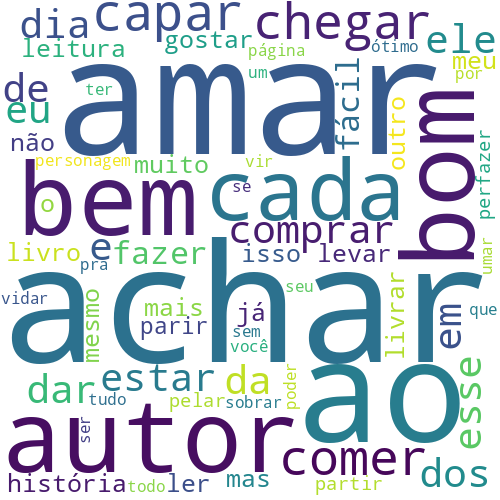

In [35]:
wordsBowTokenFrequency = ','.join( list(dfBowTokenFrequency.columns) )
wordcloud = WordCloud(
    background_color="white", 
    contour_width=3, 
    contour_color='steelblue',
    width=500,
    height=500)
wordcloud.generate( wordsBowTokenFrequency )
wordcloud.to_image()

### BoW - Sparse Matrix - Binary

In [36]:
%%time
dfBowBinary = pd.DataFrame(
    data = vectorizer.fit_transform( partialDf['sentence'] ).toarray(),
    columns = vectorizer.get_feature_names())
dfBowBinary.head(20)

CPU times: user 2.6 s, sys: 0 ns, total: 2.6 s
Wall time: 2.61 s


,,achar,amar,ao,autor,bem,bom,cada,capar,chegar,...,sobrar,ter,todo,tudo,um,umar,vidar,vir,você,ótimo
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
7,0,0,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
9,0,0,0,0,0,0,0,0,0,2,...,0,0,0,0,1,0,0,0,0,0


In [37]:
print( f'Number of columns: {len( dfBowBinary.columns)}' )

Number of columns: 69


### BoW - Sparse Matrix - TF-IDF

https://www.kaggle.com/code/k4puneet/countvectorizer-tfidf-tutorial/notebook

#### TfidfVectorizer

In [38]:
%%time
vectorizer = TfidfVectorizer( 
    analyzer = tokenizer,
    max_df = max_df,
    min_df = min_df)

CPU times: user 78 µs, sys: 5 µs, total: 83 µs
Wall time: 88 µs


In [39]:
%%time
dfBowTFIDF = pd.DataFrame(
    data = vectorizer.fit_transform( partialDf['sentence'] ).toarray(),
    columns = vectorizer.get_feature_names())
dfBowTFIDF.head(20)

CPU times: user 2.54 s, sys: 3.8 ms, total: 2.55 s
Wall time: 2.55 s


,,achar,amar,ao,autor,bem,bom,cada,capar,chegar,...,sobrar,ter,todo,tudo,um,umar,vidar,vir,você,ótimo
0,0.000000,0.0,0.00000,0.575075,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.0000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
1,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.0000,0.000000,0.000000,0.0,0.000000,0.420804,0.0
2,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.0000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
3,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.0000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
4,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.0000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
5,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.561198,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.0000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
6,0.000000,0.0,0.00000,0.000000,0.697931,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.0000,0.503821,0.000000,0.0,0.000000,0.000000,0.0
7,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.786328,0.000000,0.000000,...,0.000000,0.0,0.000000,0.0000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
8,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.608693,0.000000,0.000000,...,0.000000,0.0,0.000000,0.0000,0.000000,0.000000,0.0,0.000000,0.601086,0.0
9,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.768315,...,0.000000,0.0,0.000000,0.0000,0.309758,0.000000,0.0,0.000000,0.000000,0.0


In [40]:
print( f'Number of columns: {len( dfBowTFIDF.columns )}' )

Number of columns: 69


### Total of clusters

In [41]:
clustersTotal = 5

### Function: classReport

In [42]:
def classReport( columnLabel, clustersTotal ):

    for i in range(0, clustersTotal):

        print( '===========================================================================' )
        print( f'Representation: {columnLabel} - class: {i}' )
        print( '===========================================================================' )
        print()

        dfClass = partialDf[ partialDf[ columnLabel ] == i ]

        display( dfClass.head(10) )
        print()

        print( f'Sentences by score from class {i}' )
        print( '====================================' )
        print( dfClass[ 'review_rating' ].value_counts().sort_index( ascending=False ) )
        print()

        print( f'Examples from class {i}' )
        print( '====================================' )
        print()

        if len( dfClass['sentence'] ) >= 5:
            sentencesClass = dfClass['sentence'].sample(5)
            for sentence in sentencesClass:
                print( sentence )
                print()
                print( '-----------------------------------' )
                print()
        else:
            for sentence in dfClass['sentence']:
                print( sentence )
                print()
                print( '-----------------------------------' )
                print()
                

        print( '###########################################################################' )
        print( '###########################################################################' )
        print( '###########################################################################' )
        print()

### K-Means - BoW - Sparse Matrix - Token Frequency

In [43]:
kmeans = KMeans(n_clusters=clustersTotal, random_state=0).fit( dfBowTokenFrequency )
kmeans

KMeans(n_clusters=5, random_state=0)

#### Labels and Centroids

In [44]:
kmeans.labels_

array([0, 3, 3, 0, 0, 0, 0, 0, 0, 3, 2, 3, 4, 2, 3, 0, 3, 3, 0, 4, 0, 0,
       3, 0, 0, 3, 3, 4, 0, 1, 0, 4, 0, 2, 3, 2, 4, 3, 3, 2, 3, 3, 0, 0,
       0, 1, 0, 4, 3, 0, 3, 4, 2, 0, 4, 3, 2, 2, 2, 0, 0, 3, 3, 0, 2, 2,
       1, 4, 3, 2, 3, 0, 1, 0, 4, 3, 3, 0, 4, 3, 0, 4, 4, 4, 4, 0, 0, 0,
       0, 0, 2, 3, 2, 2, 4, 2, 3, 3, 4, 0, 1, 3, 3, 4, 0, 0, 3, 0, 0, 3,
       2, 3, 0, 0, 3, 2, 2, 1, 0, 0, 4, 3, 3, 0, 0, 0, 1, 2, 3, 0, 2, 2,
       3, 0, 3, 0, 3, 2, 3, 3, 0, 0, 4, 3, 2, 2, 4, 0, 3, 2, 0, 3, 4, 3,
       0, 0, 2, 1, 3, 0, 4, 3, 2, 3, 3, 3, 3, 3, 0, 0, 0, 3, 1, 0, 0, 4,
       0, 0, 0, 0, 2, 3, 4, 0, 0, 2, 1, 1, 3, 4, 3, 0, 0, 3, 3, 3, 2, 1,
       3, 3, 4, 2, 0, 0, 3, 4, 4, 1, 4, 2, 3, 3, 4, 0, 0, 3, 2, 0, 4, 2,
       0, 1, 4, 2, 3, 3, 2, 3, 1, 4, 0, 0, 3, 0, 4, 4, 3, 0, 3, 0, 2, 0,
       0, 2, 0, 3, 4, 0, 4, 0, 2, 2, 0, 4, 0, 3, 3, 0, 2, 0, 1, 4, 0, 2,
       4, 0, 2, 3, 0, 0, 1, 3, 3, 1, 3, 2, 2, 0, 1, 3, 3, 1, 2, 3, 4, 2,
       3, 0, 0, 3, 0, 0, 3, 3, 4, 3, 3, 3, 0, 4, 4,

In [45]:
kmeans.cluster_centers_

array([[ 1.09756098e-01,  1.82926829e-02,  6.70731707e-02,
         1.21951220e-02,  4.26829268e-02,  8.53658537e-02,
         6.09756098e-02,  4.87804878e-02,  4.87804878e-02,
         1.03658537e-01,  1.40243902e-01,  1.21951220e-01,
         3.65853659e-02,  1.28048780e-01,  3.04878049e-02,
         5.48780488e-02,  7.92682927e-02,  1.46341463e-01,
         1.82926829e-02,  4.32926829e-01,  6.70731707e-02,
         1.64634146e-01,  7.31707317e-02,  1.28048780e-01,
         9.14634146e-02,  3.65853659e-02,  1.82926829e-02,
         3.65853659e-02,  8.53658537e-02,  1.21951220e-02,
         2.43902439e-02,  1.15853659e-01,  9.14634146e-02,
         2.43902439e-02,  2.31707317e-01,  1.82926829e-02,
         3.65853659e-02,  1.03658537e-01,  6.09756098e-02,
         2.43902439e-02,  7.31707317e-02,  1.46341463e-01,
         1.34146341e-01,  1.32926829e+00,  1.21951220e-02,
         1.46341463e-01,  1.21951220e-02,  5.48780488e-02,
         4.87804878e-02,  2.43902439e-02,  3.65853659e-0

In [46]:
columnLabel = 'class__bow_token_frequency'

In [47]:
partialDf[columnLabel] = kmeans.labels_
partialDf.head()

,book_id,review_id,review_rating,sentence,class__bow_token_frequency
38853,8547000240,R1YFA07OZ6F7RW,5,modelos mentais podem nos ajudar como nos impe...,0
125772,8551006754,R2Z9HA20UXS6CY,5,por vezes você se sente encorajado por ela apr...,3
12593,8568014003,R3JRJSF17X74OY,5,livro com muita riqueza em conhecimentos,3
25740,8595083274,R2M4X3V679MK20,5,perfeito para o investidor iniciante,0
31392,6580309318,R28JD6XH22JP2K,5,quando retomei na metade pro final não consegu...,0


In [48]:
partialDf[columnLabel].value_counts().sort_index()

0    164
1     30
2     84
3    146
4     76
Name: class__bow_token_frequency, dtype: int64

#### PCA

In [49]:
pcaBowTokenFrequency = PCA( n_components=2 )
principalComponentsBowTokenFrequency = pcaBowTokenFrequency.fit_transform( dfBowTokenFrequency )
# principalComponentsBowTokenFrequency
# type(principalComponentsBowTokenFrequency)

In [50]:
'''
array([[ 1.21904561e+00, -1.18886035e+00],
       [ 2.39121079e-01, -3.42411365e-01],
       [-1.36406682e-01,  6.55526438e-01],
'''

a = []
b = []
for item in principalComponentsBowTokenFrequency:
    # print(item[0])
    a.append( item[0] )
    b.append( item[1] )

<AxesSubplot:>

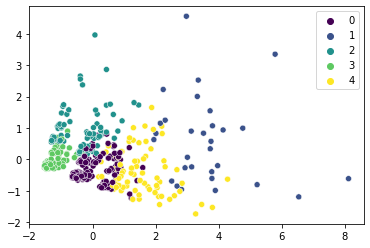

In [51]:
sns.scatterplot(
    x = a, 
    y = b,
    hue = kmeans.labels_,
    palette = 'viridis')

#### MDS

In [52]:
%%time
mds = MDS(n_components=2)
mds = mds.fit_transform( dfBowTokenFrequency )
mds.shape

CPU times: user 15 s, sys: 8.32 s, total: 23.3 s
Wall time: 6.39 s


(500, 2)

In [53]:
a = []
b = []
for item in mds:
    # print(item[0])
    a.append( item[0] )
    b.append( item[1] )

<AxesSubplot:>

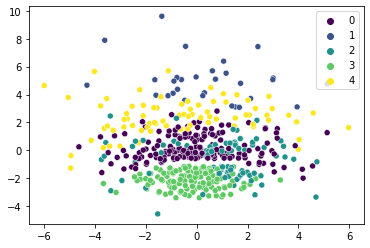

In [54]:
sns.scatterplot(
    x = a, 
    y = b,
    hue = kmeans.labels_,
    palette = 'viridis')

#### TSNE

In [55]:
%%time
tsne = TSNE(n_components=2)
tsne = tsne.fit_transform( dfBowTokenFrequency )
tsne.shape

CPU times: user 7.04 s, sys: 82.3 ms, total: 7.12 s
Wall time: 1.87 s


(500, 2)

In [56]:
a = []
b = []
for item in tsne:
    # print(item[0])
    a.append( item[0] )
    b.append( item[1] )

<AxesSubplot:>

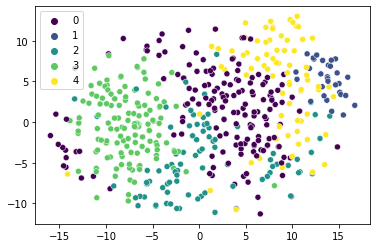

In [57]:
sns.scatterplot(
    x = a, 
    y = b,
    hue = kmeans.labels_,
    palette = 'viridis')

#### Class Report

In [58]:
classReport( columnLabel, clustersTotal )

Representation: class__bow_token_frequency - class: 0



,book_id,review_id,review_rating,sentence,class__bow_token_frequency
38853,8547000240,R1YFA07OZ6F7RW,5,modelos mentais podem nos ajudar como nos impe...,0
25740,8595083274,R2M4X3V679MK20,5,perfeito para o investidor iniciante,0
31392,6580309318,R28JD6XH22JP2K,5,quando retomei na metade pro final não consegu...,0
1870,8595081530,R2HMYNU1KCGNL3,5,bom livro nós lembra as regras básicas de lida...,0
8788,8550802751,R3LMQA5T25RY1T,2,o autor parece um pastor cita a bíblia diversa...,0
86390,8543102146,R32BSP39O4YP60,5,gostei de como cada tema é abordado a cada nov...,0
130894,8501105732,R1RYBRC24EXZ2A,5,você quer saber o que vai acontecer a cada cap...,0
118302,8532530788,R2CRQQML14I9RN,5,o livro é se muita qualidade capa dura textur...,0
41749,6555127279,R2OM4S2CWK9CBF,4,uma ótima história porém a panini sempre ferra...,0
9392,8550802751,RARFUGPBBHZ7N,1,porém o meu livro veio com a folha branca e e...,0



Sentences by score from class 0
5    131
4     16
3      6
2      4
1      7
Name: review_rating, dtype: int64

Examples from class 0

o poder do habito ajuda

-----------------------------------

o estilo da escrita me agradou muito

-----------------------------------

o livro é ótimo e chegou em  dias

-----------------------------------

ainda estou iniciando a leitura mas ja vi que é muito bom

-----------------------------------

todos os exemplos toda estrutura os frameworks problemas e tudo mais tudo é java

-----------------------------------

###########################################################################
###########################################################################
###########################################################################

Representation: class__bow_token_frequency - class: 1



,book_id,review_id,review_rating,sentence,class__bow_token_frequency
175102,8595081514,R3FC1HXSD2RRRN,4,no fim da releitura o encontro com o príncipe ...,1
3873,8501112518,R2NO964W87CT2G,4,acho que a autora conseguiu descrever muito be...,1
45668,8539004119,R22SLQVEE40MPW,5,traz situações que frequentemente passam sem p...,1
169977,8565765695,R487HZP3EV0IE,5,eu li o livro e avaliei a qualidade de todas a...,1
109420,8542209826,R1XLY7GU0T4TQL,5,ahhh me esqueci de dizer as anos rune tinha a...,1
59059,8573258926,RAMRD5BS7KAW2,5,uma escrita simples e que nos ajuda a compreen...,1
166027,8535932879,R118Y86WF9P8P6,5,djamila consegue condensar pontos complexos da...,1
51207,8595084742,R3KMOOKEIFSX13,5,não uma toca desagradável suja e úmida cheia d...,1
129872,8501105732,RFV948S4BHH37,5,uma história muito emocionante e te deixa do c...,1
133951,8543105293,R1M9V8IHI5SH7B,3,é na verdade um pequeno manual e catalogo das ...,1



Sentences by score from class 1
5    19
4     6
3     2
1     3
Name: review_rating, dtype: int64

Examples from class 1

nós vamos conhecer a história de uma banda de rock em pleno os anos  são pessoas comuns buscando seus sonhos e almejam a ascensão⠀⠀eu amei

-----------------------------------

uma história muito emocionante e te deixa do começo ao fim querendo descobrir o que aconteceu no passado para enfim entender o porquê de tudo que ocorre durante o texto

-----------------------------------

não uma toca desagradável suja e úmida cheia de restos de minhocas e com cheiro de lodo tampouco uma toca seca vazia e arenosa sem nada em que sentar ou o que comer: era a toca de um hobbit e isso quer dizer conforto

-----------------------------------

o livro chegou todo amassado tanto na parte da frente quanto na parte de trás e incluindo praticamente todas as folhas que estão amassadas no topo da página

-----------------------------------

é na verdade um pequeno manual e catalogo d

,book_id,review_id,review_rating,sentence,class__bow_token_frequency
147973,8551002341,R35H5J1I9MCVYN,4,romance clichezinholevemente difícil de se pre...,2
115350,8582892101,R3FWRDJBS3D6NV,5,um livro muito útil para todos que desejam con...,2
46961,8539004119,ROWCEHG3AE6KX,5,linguagem de fácil entendimento com histórias ...,2
110217,8542209826,R1R5CWCL40X87P,5,muito gostoso de ler como ler um poema de amor...,2
51286,8595084742,R7U0EOLATBJDS,5,com isso é inevitável o apego ao personagem qu...,2
52605,8595084742,R2I10BU4Y4RCA8,3,esse ano resolvi entrar no mundo de j,2
15128,8568014003,R311UAWNMKSMLS,4,só faltou o marcador de páginas,2
7893,8501112518,ROMW0VTZ0KYPI,5,primeiro aborda um romance avassalador que te ...,2
39146,8547000240,R139R3LKMDE4QU,3,achei cheio de frases lugar comum que já ouvim...,2
167434,8535932879,R2JYJ6WDNUZ1YY,5,compacto eu diria e maravilhoso só lendo pra e...,2



Sentences by score from class 2
5    67
4     9
3     4
1     4
Name: review_rating, dtype: int64

Examples from class 2

livro gostoso de ler emocionante e divertido onde vc se coloca no lugar de todos

-----------------------------------

ensina sobre educação financeira de uma maneira bem simples e com exemplos que marcam

-----------------------------------

foi também de grande ajuda pra mim visto que estou fazendo uma monografia a respeito da seletividade penal e tem vários conteúdos enriquecedores

-----------------------------------

romance clichezinholevemente difícil de se prender no começomas depois que engata é maravilhoso

-----------------------------------

para os adoradores de romance esse aí vc lê em  dias no máximo de tão maravilhoso

-----------------------------------

###########################################################################
###########################################################################
#############################################

,book_id,review_id,review_rating,sentence,class__bow_token_frequency
125772,8551006754,R2Z9HA20UXS6CY,5,por vezes você se sente encorajado por ela apr...,3
12593,8568014003,R3JRJSF17X74OY,5,livro com muita riqueza em conhecimentos,3
52956,8595084742,R1E05P3T786LNA,5,demorou um pouquinho para chegar mas chegou em...,3
128717,8584391673,R3H8HGELHMIUGZ,5,amei lindo livro,3
4573,8501112518,R2SYH9QVTSKKEZ,5,colleen hoover não decepciona,3
120751,8532530788,RR90YCMQ5CDNR,5,muito bom chegou bem rápido,3
45984,8539004119,R2EALPGDC1EOW2,3,explica como se cria um hábito como ele pode s...,3
143074,8576849941,R1VEDDCPFDQ5ND,3,tive indicações para ler esse livro e por isso...,3
150561,8580412382,R2GC1Q9GYIMVB6,5,estou,3
149693,8580412382,R26810GCHBIJ59,5,sem ligar para leve parte amassada,3



Sentences by score from class 3
5    117
4     12
3     10
2      4
1      3
Name: review_rating, dtype: int64

Examples from class 3

como ele é acertivo

-----------------------------------

veio da editora esse erro

-----------------------------------

ameiiiiiiiiiiiiiiii

-----------------------------------

lindas historias

-----------------------------------

grata 🐷

-----------------------------------

###########################################################################
###########################################################################
###########################################################################

Representation: class__bow_token_frequency - class: 4



,book_id,review_id,review_rating,sentence,class__bow_token_frequency
161499,8532649963,R2VHOT5IOOTTSA,5,não atoa você como parte dessa sociedade do ca...,4
145282,8576849941,R3ABY16MEC65GG,5,livro muito bom gostei do jeito que o autor me...,4
83404,8575422391,RU6GC1PZWCTRM,5,para quem já leu outros livros de autoajuda ir...,4
41570,8543104335,R3IZ4LB0UZN1OT,5,livros de autoajuda nunca foram meu forte a mo...,4
86585,8532606261,R3A81PTN8U25PC,5,recomendo esse livro a todos os que buscam des...,4
78029,8543108683,R1KKGE4LVXOPGT,5,posso dizer que o livro é realmente muito bom ...,4
56667,6555651059,R7P6QIO1XQQV5,5,comprei livros no total decidi avaliar pelo b...,4
39388,8542218752,RHRQN0F1BC9EV,5,o único ponto que vi que poderia deixar mais c...,4
40379,8543104335,R8F26DHSSEP2W,5,o livro tocou profundamente em questões pessoa...,4
138809,8565765482,R306N87VZCS2I4,5,a autora utiliza muitas metáforas desnecessári...,4



Sentences by score from class 4
5    54
4    10
3     5
2     4
1     3
Name: review_rating, dtype: int64

Examples from class 4

amei a história as expressões dos personagens o design do livro

-----------------------------------

daquele tipo que te instiga e que faz você não querer largar até terminar e entender o que acontece

-----------------------------------

é uma obra muito importante para jovens lerem recomendo muito em relação à edição não tenho nada a falar a diagramação é boa e a capa bonita é uma ótima edição custo benefício

-----------------------------------

excelente edição todo o capricho foi feito não apenas para agradar a fanbase mas trazer finalmente edições decentes à altura do professor de oxford

-----------------------------------

o livro é bom mas não é o melhor dos livros desta editora

-----------------------------------

###########################################################################
#########################################################

### K-Means - BoW - Sparse Matrix - Binary

In [59]:
kmeans = KMeans(n_clusters=clustersTotal, random_state=0).fit( dfBowBinary )
kmeans

KMeans(n_clusters=5, random_state=0)

#### Labels and Centroids

In [60]:
kmeans.labels_

array([0, 3, 3, 0, 0, 0, 0, 0, 0, 3, 2, 3, 4, 2, 3, 0, 3, 3, 0, 4, 0, 0,
       3, 0, 0, 3, 3, 4, 0, 1, 0, 4, 0, 2, 3, 2, 4, 3, 3, 2, 3, 3, 0, 0,
       0, 1, 0, 4, 3, 0, 3, 4, 2, 0, 4, 3, 2, 2, 2, 0, 0, 3, 3, 0, 2, 2,
       1, 4, 3, 2, 3, 0, 1, 0, 4, 3, 3, 0, 4, 3, 0, 4, 4, 4, 4, 0, 0, 0,
       0, 0, 2, 3, 2, 2, 4, 2, 3, 3, 4, 0, 1, 3, 3, 4, 0, 0, 3, 0, 0, 3,
       2, 3, 0, 0, 3, 2, 2, 1, 0, 0, 4, 3, 3, 0, 0, 0, 1, 2, 3, 0, 2, 2,
       3, 0, 3, 0, 3, 2, 3, 3, 0, 0, 4, 3, 2, 2, 4, 0, 3, 2, 0, 3, 4, 3,
       0, 0, 2, 1, 3, 0, 4, 3, 2, 3, 3, 3, 3, 3, 0, 0, 0, 3, 1, 0, 0, 4,
       0, 0, 0, 0, 2, 3, 4, 0, 0, 2, 1, 1, 3, 4, 3, 0, 0, 3, 3, 3, 2, 1,
       3, 3, 4, 2, 0, 0, 3, 4, 4, 1, 4, 2, 3, 3, 4, 0, 0, 3, 2, 0, 4, 2,
       0, 1, 4, 2, 3, 3, 2, 3, 1, 4, 0, 0, 3, 0, 4, 4, 3, 0, 3, 0, 2, 0,
       0, 2, 0, 3, 4, 0, 4, 0, 2, 2, 0, 4, 0, 3, 3, 0, 2, 0, 1, 4, 0, 2,
       4, 0, 2, 3, 0, 0, 1, 3, 3, 1, 3, 2, 2, 0, 1, 3, 3, 1, 2, 3, 4, 2,
       3, 0, 0, 3, 0, 0, 3, 3, 4, 3, 3, 3, 0, 4, 4,

In [61]:
kmeans.cluster_centers_

array([[ 1.09756098e-01,  1.82926829e-02,  6.70731707e-02,
         1.21951220e-02,  4.26829268e-02,  8.53658537e-02,
         6.09756098e-02,  4.87804878e-02,  4.87804878e-02,
         1.03658537e-01,  1.40243902e-01,  1.21951220e-01,
         3.65853659e-02,  1.28048780e-01,  3.04878049e-02,
         5.48780488e-02,  7.92682927e-02,  1.46341463e-01,
         1.82926829e-02,  4.32926829e-01,  6.70731707e-02,
         1.64634146e-01,  7.31707317e-02,  1.28048780e-01,
         9.14634146e-02,  3.65853659e-02,  1.82926829e-02,
         3.65853659e-02,  8.53658537e-02,  1.21951220e-02,
         2.43902439e-02,  1.15853659e-01,  9.14634146e-02,
         2.43902439e-02,  2.31707317e-01,  1.82926829e-02,
         3.65853659e-02,  1.03658537e-01,  6.09756098e-02,
         2.43902439e-02,  7.31707317e-02,  1.46341463e-01,
         1.34146341e-01,  1.32926829e+00,  1.21951220e-02,
         1.46341463e-01,  1.21951220e-02,  5.48780488e-02,
         4.87804878e-02,  2.43902439e-02,  3.65853659e-0

In [62]:
columnLabel = 'class__bow_binary'

In [63]:
partialDf[columnLabel] = kmeans.labels_
partialDf.head()

,book_id,review_id,review_rating,sentence,class__bow_token_frequency,class__bow_binary
38853,8547000240,R1YFA07OZ6F7RW,5,modelos mentais podem nos ajudar como nos impe...,0,0
125772,8551006754,R2Z9HA20UXS6CY,5,por vezes você se sente encorajado por ela apr...,3,3
12593,8568014003,R3JRJSF17X74OY,5,livro com muita riqueza em conhecimentos,3,3
25740,8595083274,R2M4X3V679MK20,5,perfeito para o investidor iniciante,0,0
31392,6580309318,R28JD6XH22JP2K,5,quando retomei na metade pro final não consegu...,0,0


In [64]:
partialDf[columnLabel].value_counts().sort_index()

0    164
1     30
2     84
3    146
4     76
Name: class__bow_binary, dtype: int64

#### PCA

In [65]:
pcaBowBinary = PCA( n_components=2 )
principalComponentsBowBinary = pcaBowBinary.fit_transform( dfBowBinary )
# principalComponentsBowBinary
# type(principalComponentsBowBinary)

In [66]:
'''
array([[ 1.21904561e+00, -1.18886035e+00],
       [ 2.39121079e-01, -3.42411365e-01],
       [-1.36406682e-01,  6.55526438e-01],
'''

a = []
b = []
for item in principalComponentsBowBinary:
    # print(item[0])
    a.append( item[0] )
    b.append( item[1] )

<AxesSubplot:>

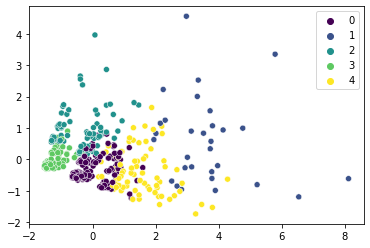

In [67]:
sns.scatterplot(
    x = a, 
    y = b,
    hue = kmeans.labels_,
    palette = 'viridis')

#### MDS

In [68]:
%%time
mds = MDS(n_components=2)
mds = mds.fit_transform( dfBowBinary )
mds.shape

CPU times: user 14.6 s, sys: 8.23 s, total: 22.8 s
Wall time: 6.06 s


(500, 2)

In [69]:
a = []
b = []
for item in mds:
    # print(item[0])
    a.append( item[0] )
    b.append( item[1] )

<AxesSubplot:>

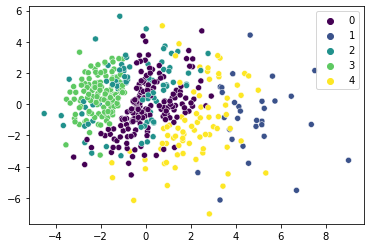

In [70]:
sns.scatterplot(
    x = a, 
    y = b,
    hue = kmeans.labels_,
    palette = 'viridis')

#### TSNE

In [71]:
%%time
tsne = TSNE(n_components=2)
tsne = tsne.fit_transform( dfBowBinary )
tsne.shape

CPU times: user 6.76 s, sys: 82.6 ms, total: 6.84 s
Wall time: 1.77 s


(500, 2)

In [72]:
a = []
b = []
for item in tsne:
    # print(item[0])
    a.append( item[0] )
    b.append( item[1] )

<AxesSubplot:>

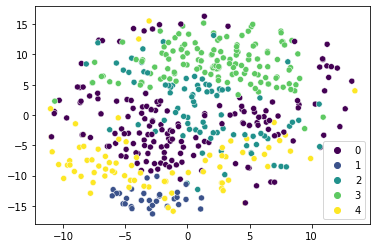

In [73]:
sns.scatterplot(
    x = a, 
    y = b,
    hue = kmeans.labels_,
    palette = 'viridis')

#### Class Report

In [74]:
classReport( columnLabel, clustersTotal )

Representation: class__bow_binary - class: 0



,book_id,review_id,review_rating,sentence,class__bow_token_frequency,class__bow_binary
38853,8547000240,R1YFA07OZ6F7RW,5,modelos mentais podem nos ajudar como nos impe...,0,0
25740,8595083274,R2M4X3V679MK20,5,perfeito para o investidor iniciante,0,0
31392,6580309318,R28JD6XH22JP2K,5,quando retomei na metade pro final não consegu...,0,0
1870,8595081530,R2HMYNU1KCGNL3,5,bom livro nós lembra as regras básicas de lida...,0,0
8788,8550802751,R3LMQA5T25RY1T,2,o autor parece um pastor cita a bíblia diversa...,0,0
86390,8543102146,R32BSP39O4YP60,5,gostei de como cada tema é abordado a cada nov...,0,0
130894,8501105732,R1RYBRC24EXZ2A,5,você quer saber o que vai acontecer a cada cap...,0,0
118302,8532530788,R2CRQQML14I9RN,5,o livro é se muita qualidade capa dura textur...,0,0
41749,6555127279,R2OM4S2CWK9CBF,4,uma ótima história porém a panini sempre ferra...,0,0
9392,8550802751,RARFUGPBBHZ7N,1,porém o meu livro veio com a folha branca e e...,0,0



Sentences by score from class 0
5    131
4     16
3      6
2      4
1      7
Name: review_rating, dtype: int64

Examples from class 0

ameiiiiiiquando comecei a ler não quis mais parar te prende do começo ao fim

-----------------------------------

o milagre da manhã foi um despertar para como eu estava vivendo minha vida

-----------------------------------

leitura obrigatória para a vida toda

-----------------------------------

chegou bem antes do prazo por não ter no estoque estava previsto pra chegar no fim do mês e chegou dia 

-----------------------------------

sério superr recomendoassim eu tenho  anos e amei mas nao tem idade sabe minha mae que tem  tambem amou entaoso digo a voceis perfeitoo

-----------------------------------

###########################################################################
###########################################################################
###########################################################################

Representation: 

,book_id,review_id,review_rating,sentence,class__bow_token_frequency,class__bow_binary
175102,8595081514,R3FC1HXSD2RRRN,4,no fim da releitura o encontro com o príncipe ...,1,1
3873,8501112518,R2NO964W87CT2G,4,acho que a autora conseguiu descrever muito be...,1,1
45668,8539004119,R22SLQVEE40MPW,5,traz situações que frequentemente passam sem p...,1,1
169977,8565765695,R487HZP3EV0IE,5,eu li o livro e avaliei a qualidade de todas a...,1,1
109420,8542209826,R1XLY7GU0T4TQL,5,ahhh me esqueci de dizer as anos rune tinha a...,1,1
59059,8573258926,RAMRD5BS7KAW2,5,uma escrita simples e que nos ajuda a compreen...,1,1
166027,8535932879,R118Y86WF9P8P6,5,djamila consegue condensar pontos complexos da...,1,1
51207,8595084742,R3KMOOKEIFSX13,5,não uma toca desagradável suja e úmida cheia d...,1,1
129872,8501105732,RFV948S4BHH37,5,uma história muito emocionante e te deixa do c...,1,1
133951,8543105293,R1M9V8IHI5SH7B,3,é na verdade um pequeno manual e catalogo das ...,1,1



Sentences by score from class 1
5    19
4     6
3     2
1     3
Name: review_rating, dtype: int64

Examples from class 1

o livro nos faz refletir sobre a construção de hábitos e nos mostra como podemos agir para usar esta construção como apoio no alcance de objetivos

-----------------------------------

importante: o aprendizado da linguagem de serviço exige que reexaminemos nossos estereótipos dos papéis de homem e mulher presentes: gostar de ganhar presentes  aqui não se refere a presentes caros mas a qualquer lembrança mesmo que seja um presente feito pela própria pessoa  como um doce uma flor uma bilhete etc toque físico: gostar de ser tocado abraçado beijado andar de mãos dadas passar a mão pelos cabelos fazer um carinho nas costas etc

-----------------------------------

como exemplo do nível do livro o autor demonstra seus pontos de vista através de argumentos fáceis de se observar ele usa o exemplo do filme malévola e outros filmes atuais da disney em muitas partes e em tud

,book_id,review_id,review_rating,sentence,class__bow_token_frequency,class__bow_binary
147973,8551002341,R35H5J1I9MCVYN,4,romance clichezinholevemente difícil de se pre...,2,2
115350,8582892101,R3FWRDJBS3D6NV,5,um livro muito útil para todos que desejam con...,2,2
46961,8539004119,ROWCEHG3AE6KX,5,linguagem de fácil entendimento com histórias ...,2,2
110217,8542209826,R1R5CWCL40X87P,5,muito gostoso de ler como ler um poema de amor...,2,2
51286,8595084742,R7U0EOLATBJDS,5,com isso é inevitável o apego ao personagem qu...,2,2
52605,8595084742,R2I10BU4Y4RCA8,3,esse ano resolvi entrar no mundo de j,2,2
15128,8568014003,R311UAWNMKSMLS,4,só faltou o marcador de páginas,2,2
7893,8501112518,ROMW0VTZ0KYPI,5,primeiro aborda um romance avassalador que te ...,2,2
39146,8547000240,R139R3LKMDE4QU,3,achei cheio de frases lugar comum que já ouvim...,2,2
167434,8535932879,R2JYJ6WDNUZ1YY,5,compacto eu diria e maravilhoso só lendo pra e...,2,2



Sentences by score from class 2
5    67
4     9
3     4
1     4
Name: review_rating, dtype: int64

Examples from class 2

livro excelentemuito bom de lernota 

-----------------------------------

entrega da amazon de confiança e ótima rastreabilidade

-----------------------------------

esse livro deveria ser de leitura obrigatória no primeiro ano do ensino fundamental

-----------------------------------

história envolvente e de fácil leitura terminei o livro eem pouquíssimos dias

-----------------------------------

conhecer as cinco linguagens do amor é essencial para vivermos de forma mais harmônica em nossos relacionamentos

-----------------------------------

###########################################################################
###########################################################################
###########################################################################

Representation: class__bow_binary - class: 3



,book_id,review_id,review_rating,sentence,class__bow_token_frequency,class__bow_binary
125772,8551006754,R2Z9HA20UXS6CY,5,por vezes você se sente encorajado por ela apr...,3,3
12593,8568014003,R3JRJSF17X74OY,5,livro com muita riqueza em conhecimentos,3,3
52956,8595084742,R1E05P3T786LNA,5,demorou um pouquinho para chegar mas chegou em...,3,3
128717,8584391673,R3H8HGELHMIUGZ,5,amei lindo livro,3,3
4573,8501112518,R2SYH9QVTSKKEZ,5,colleen hoover não decepciona,3,3
120751,8532530788,RR90YCMQ5CDNR,5,muito bom chegou bem rápido,3,3
45984,8539004119,R2EALPGDC1EOW2,3,explica como se cria um hábito como ele pode s...,3,3
143074,8576849941,R1VEDDCPFDQ5ND,3,tive indicações para ler esse livro e por isso...,3,3
150561,8580412382,R2GC1Q9GYIMVB6,5,estou,3,3
149693,8580412382,R26810GCHBIJ59,5,sem ligar para leve parte amassada,3,3



Sentences by score from class 3
5    117
4     12
3     10
2      4
1      3
Name: review_rating, dtype: int64

Examples from class 3

chegou muito bem embalado e muito antes do prazo

-----------------------------------

estou

-----------------------------------

chegou tudo em perfeito estado e extremamente rápido

-----------------------------------

lindo boxer amei

-----------------------------------

usa histórias pra explicar finanças achei bem didático

-----------------------------------

###########################################################################
###########################################################################
###########################################################################

Representation: class__bow_binary - class: 4



,book_id,review_id,review_rating,sentence,class__bow_token_frequency,class__bow_binary
161499,8532649963,R2VHOT5IOOTTSA,5,não atoa você como parte dessa sociedade do ca...,4,4
145282,8576849941,R3ABY16MEC65GG,5,livro muito bom gostei do jeito que o autor me...,4,4
83404,8575422391,RU6GC1PZWCTRM,5,para quem já leu outros livros de autoajuda ir...,4,4
41570,8543104335,R3IZ4LB0UZN1OT,5,livros de autoajuda nunca foram meu forte a mo...,4,4
86585,8532606261,R3A81PTN8U25PC,5,recomendo esse livro a todos os que buscam des...,4,4
78029,8543108683,R1KKGE4LVXOPGT,5,posso dizer que o livro é realmente muito bom ...,4,4
56667,6555651059,R7P6QIO1XQQV5,5,comprei livros no total decidi avaliar pelo b...,4,4
39388,8542218752,RHRQN0F1BC9EV,5,o único ponto que vi que poderia deixar mais c...,4,4
40379,8543104335,R8F26DHSSEP2W,5,o livro tocou profundamente em questões pessoa...,4,4
138809,8565765482,R306N87VZCS2I4,5,a autora utiliza muitas metáforas desnecessári...,4,4



Sentences by score from class 4
5    54
4    10
3     5
2     4
1     3
Name: review_rating, dtype: int64

Examples from class 4

se por um lado é possível perceber o crescimento no desenvolvimento dos personagens por outro as relações amorosas são um fiasco

-----------------------------------

em lady killers você pode achar que sabe de tudo o que está lendo mas não é isto a capa neon as imagens as notas tudo isto todas estas coisas que você acredita saber tão bem porque está lendo um livro sobre pessoas ruins que mataram outras pessoas é uma parte muito pequena do livro

-----------------------------------

o livro tocou profundamente em questões pessoais e precisei até respirar uns dias até retomar e processar o que vivi e estava ali sendo dissecado

-----------------------------------

enquanto os outros se limitavam a dizer se esforce ou tenha metas esse nos dá uma idéia mais concreta do que deve ser feito

-----------------------------------

no geral é um bom livro e indico a 

### K-Means - BoW - Sparse Matrix - TF-IDF

In [75]:
kmeans = KMeans(n_clusters=clustersTotal, random_state=0).fit( dfBowTFIDF )
kmeans

KMeans(n_clusters=5, random_state=0)

#### Labels and Centroids

In [76]:
kmeans.labels_

array([3, 3, 2, 0, 4, 1, 3, 1, 3, 0, 1, 0, 3, 1, 4, 2, 0, 3, 0, 2, 0, 0,
       4, 2, 3, 0, 0, 3, 3, 4, 4, 1, 0, 1, 0, 1, 3, 0, 2, 3, 2, 0, 3, 3,
       3, 3, 0, 2, 0, 1, 0, 4, 1, 4, 3, 0, 1, 1, 1, 0, 4, 0, 3, 4, 1, 1,
       3, 3, 2, 1, 2, 3, 1, 3, 2, 3, 4, 2, 3, 2, 3, 2, 2, 3, 4, 4, 4, 3,
       3, 3, 1, 0, 1, 1, 4, 1, 0, 0, 3, 3, 1, 2, 0, 4, 3, 2, 4, 3, 0, 0,
       0, 0, 3, 2, 3, 1, 1, 3, 0, 0, 4, 2, 0, 4, 3, 3, 3, 1, 0, 3, 1, 1,
       0, 4, 0, 2, 2, 1, 0, 0, 3, 3, 1, 0, 4, 2, 3, 3, 0, 1, 2, 0, 4, 0,
       3, 3, 2, 1, 0, 3, 1, 3, 1, 2, 4, 0, 2, 0, 0, 0, 3, 0, 3, 3, 4, 1,
       1, 2, 3, 3, 1, 0, 3, 3, 0, 1, 3, 1, 0, 3, 2, 1, 2, 0, 3, 0, 1, 3,
       4, 0, 3, 2, 3, 0, 4, 3, 4, 3, 2, 1, 0, 0, 0, 0, 2, 2, 1, 3, 1, 1,
       3, 3, 3, 1, 4, 0, 3, 0, 3, 3, 1, 0, 0, 3, 0, 3, 2, 3, 0, 3, 2, 2,
       1, 1, 3, 0, 2, 3, 4, 3, 2, 1, 3, 1, 2, 0, 3, 2, 1, 2, 1, 4, 4, 1,
       3, 4, 1, 3, 0, 2, 3, 4, 0, 1, 2, 1, 0, 3, 3, 0, 0, 3, 1, 3, 4, 1,
       2, 0, 3, 0, 2, 3, 0, 0, 2, 0, 0, 0, 3, 2, 4,

In [77]:
kmeans.cluster_centers_

array([[ 6.95826015e-02,  1.82523371e-02,  7.17965456e-02,
         3.83801774e-03,  3.15312443e-03,  9.39743231e-02,
         2.21952410e-02,  4.58566344e-03,  2.09925604e-02,
         1.18928828e-01,  3.45322488e-02,  6.77475726e-03,
         3.41927790e-02,  2.87684923e-02,  5.43843599e-03,
         1.22272678e-02,  4.66084725e-02,  4.74603274e-02,
         9.66801053e-03,  7.22093826e-02,  2.41341897e-02,
         6.76929145e-02,  2.25313827e-02,  8.99401162e-02,
         1.71271940e-02,  5.30866921e-03,  0.00000000e+00,
         3.15974895e-02,  1.59735986e-02,  1.45849724e-02,
         1.51049312e-02,  1.86159423e-02,  3.35724597e-02,
         1.00272103e-02,  4.54257413e-02,  2.27623485e-02,
         1.37518360e-02,  2.16300456e-02,  1.52165739e-02,
         2.12537586e-02,  8.08490737e-02,  3.59998655e-02,
         1.22520262e-02,  5.30272024e-02,  6.21262210e-03,
         6.19159140e-02,  4.58886970e-03,  2.74904162e-03,
         4.75924417e-02,  8.67361738e-18,  1.73472348e-1

In [78]:
columnLabel = 'class__bow_tfidf'

In [79]:
partialDf[columnLabel] = kmeans.labels_
partialDf.head()

,book_id,review_id,review_rating,sentence,class__bow_token_frequency,class__bow_binary,class__bow_tfidf
38853,8547000240,R1YFA07OZ6F7RW,5,modelos mentais podem nos ajudar como nos impe...,0,0,3
125772,8551006754,R2Z9HA20UXS6CY,5,por vezes você se sente encorajado por ela apr...,3,3,3
12593,8568014003,R3JRJSF17X74OY,5,livro com muita riqueza em conhecimentos,3,3,2
25740,8595083274,R2M4X3V679MK20,5,perfeito para o investidor iniciante,0,0,0
31392,6580309318,R28JD6XH22JP2K,5,quando retomei na metade pro final não consegu...,0,0,4


In [80]:
partialDf[columnLabel].value_counts().sort_index()

0    118
1     88
2     89
3    136
4     69
Name: class__bow_tfidf, dtype: int64

#### PCA

In [81]:
pca = PCA( n_components=2 )
principalComponents = pca.fit_transform( dfBowTFIDF )

In [82]:
'''
array([[ 1.21904561e+00, -1.18886035e+00],
       [ 2.39121079e-01, -3.42411365e-01],
       [-1.36406682e-01,  6.55526438e-01],
'''

a = []
b = []
for item in principalComponents:
    # print(item[0])
    a.append( item[0] )
    b.append( item[1] )

<AxesSubplot:>

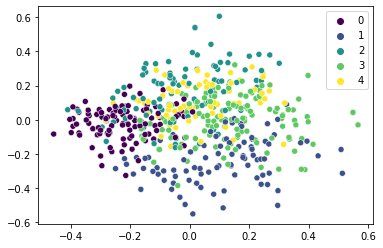

In [83]:
sns.scatterplot(
    x = a, 
    y = b,
    hue = kmeans.labels_,
    palette = 'viridis')

#### MDS

In [84]:
%%time
mds = MDS(n_components=2)
mds = mds.fit_transform( dfBowTFIDF )
mds.shape

CPU times: user 16.1 s, sys: 9.82 s, total: 25.9 s
Wall time: 7.67 s


(500, 2)

In [85]:
a = []
b = []
for item in mds:
    # print(item[0])
    a.append( item[0] )
    b.append( item[1] )

<AxesSubplot:>

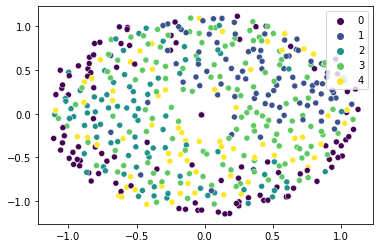

In [86]:
sns.scatterplot(
    x = a, 
    y = b,
    hue = kmeans.labels_,
    palette = 'viridis')

#### TSNE

In [87]:
%%time
tsne = TSNE(n_components=2)
tsne = tsne.fit_transform( dfBowTFIDF )
tsne.shape

CPU times: user 6.25 s, sys: 114 ms, total: 6.36 s
Wall time: 1.67 s


(500, 2)

In [88]:
a = []
b = []
for item in tsne:
    # print(item[0])
    a.append( item[0] )
    b.append( item[1] )

<AxesSubplot:>

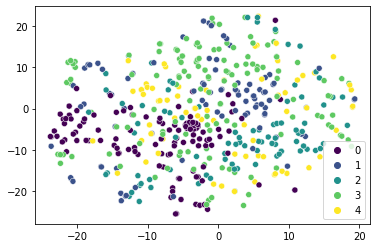

In [89]:
sns.scatterplot(
    x = a, 
    y = b,
    hue = kmeans.labels_,
    palette = 'viridis')

#### Class Report

In [90]:
classReport( columnLabel, clustersTotal )

Representation: class__bow_tfidf - class: 0



,book_id,review_id,review_rating,sentence,class__bow_token_frequency,class__bow_binary,class__bow_tfidf
25740,8595083274,R2M4X3V679MK20,5,perfeito para o investidor iniciante,0,0,0
52956,8595084742,R1E05P3T786LNA,5,demorou um pouquinho para chegar mas chegou em...,3,3,0
128717,8584391673,R3H8HGELHMIUGZ,5,amei lindo livro,3,3,0
120751,8532530788,RR90YCMQ5CDNR,5,muito bom chegou bem rápido,3,3,0
41749,6555127279,R2OM4S2CWK9CBF,4,uma ótima história porém a panini sempre ferra...,0,0,0
9392,8550802751,RARFUGPBBHZ7N,1,porém o meu livro veio com a folha branca e e...,0,0,0
49372,8539004119,R1XMMYPYPPTBXJ,5,amei o produtochegou em perfeito estado,0,0,0
150561,8580412382,R2GC1Q9GYIMVB6,5,estou,3,3,0
149693,8580412382,R26810GCHBIJ59,5,sem ligar para leve parte amassada,3,3,0
144346,8576849941,R3HJAAYS6LLTTK,5,o milagre da manhã foi um despertar para como ...,0,0,0



Sentences by score from class 0
5    100
4     10
3      3
2      1
1      4
Name: review_rating, dtype: int64

Examples from class 0

gostei 👍

-----------------------------------

a entrega foi super rápida e chegou bem embalado e certinho

-----------------------------------

chegou antes do tempo me deixando bem feliz

-----------------------------------

já me sinto bem melhor e não cheguei no dia  ainda

-----------------------------------

uns dos meus livros favoritos

-----------------------------------

###########################################################################
###########################################################################
###########################################################################

Representation: class__bow_tfidf - class: 1



,book_id,review_id,review_rating,sentence,class__bow_token_frequency,class__bow_binary,class__bow_tfidf
1870,8595081530,R2HMYNU1KCGNL3,5,bom livro nós lembra as regras básicas de lida...,0,0,1
86390,8543102146,R32BSP39O4YP60,5,gostei de como cada tema é abordado a cada nov...,0,0,1
147973,8551002341,R35H5J1I9MCVYN,4,romance clichezinholevemente difícil de se pre...,2,2,1
115350,8582892101,R3FWRDJBS3D6NV,5,um livro muito útil para todos que desejam con...,2,2,1
41570,8543104335,R3IZ4LB0UZN1OT,5,livros de autoajuda nunca foram meu forte a mo...,4,4,1
46961,8539004119,ROWCEHG3AE6KX,5,linguagem de fácil entendimento com histórias ...,2,2,1
110217,8542209826,R1R5CWCL40X87P,5,muito gostoso de ler como ler um poema de amor...,2,2,1
170911,8565765695,R3U7F02W9KX1AL,3,a amazon arrasa na hora de entrega rápida poré...,0,0,1
52605,8595084742,R2I10BU4Y4RCA8,3,esse ano resolvi entrar no mundo de j,2,2,1
15128,8568014003,R311UAWNMKSMLS,4,só faltou o marcador de páginas,2,2,1



Sentences by score from class 1
5    67
4     9
3     7
1     5
Name: review_rating, dtype: int64

Examples from class 1

riqueza de texto e personagens fiquei encantada

-----------------------------------

conteúdo informativo de muita qualidade e seriedade ja estou lendo pela segunda vez

-----------------------------------

queria ler ele de novo pela primeira vez sempre

-----------------------------------

comprei para estudar um pouco mais de renda variável porém não tinha tanto conteúdo no entanto o investidor deve lembrar da inportância de estudar renda fixa então foi uma ótima revisão para mim

-----------------------------------

linguagem de fácil entendimento com histórias reais

-----------------------------------

###########################################################################
###########################################################################
###########################################################################

Representation: class__bow_tfid

,book_id,review_id,review_rating,sentence,class__bow_token_frequency,class__bow_binary,class__bow_tfidf
12593,8568014003,R3JRJSF17X74OY,5,livro com muita riqueza em conhecimentos,3,3,2
118302,8532530788,R2CRQQML14I9RN,5,o livro é se muita qualidade capa dura textur...,0,0,2
145282,8576849941,R3ABY16MEC65GG,5,livro muito bom gostei do jeito que o autor me...,4,4,2
80293,8575422391,RQMRBTWDN6VJ3,5,esse livro me trouxe excelentes insights que m...,0,0,2
32852,6580309318,R32YLDW1DWSYOC,5,itamar é realmente genial,3,3,2
161188,8532649963,R6MG9K474ZFZC,5,aquela violência neuronal que leva ao infarto ...,3,3,2
78029,8543108683,R1KKGE4LVXOPGT,5,posso dizer que o livro é realmente muito bom ...,4,4,2
6856,8501112518,R37PGVP62FXG6R,5,livro mto bom,3,3,2
57949,8573258926,R1UXCJ09FUZH3I,5,como ele é acertivo,3,3,2
138809,8565765482,R306N87VZCS2I4,5,a autora utiliza muitas metáforas desnecessári...,4,4,2



Sentences by score from class 2
5    67
4     9
3     8
2     2
1     3
Name: review_rating, dtype: int64

Examples from class 2

ler o avesso da pele foi uma experiência muito única pra mim tanto pelo estilo do texto mas principalmente pelo conteúdo da história

-----------------------------------

o livro é se muita qualidade capa dura  textura da capa muito bem feita

-----------------------------------

o livro é ótimo porém a diagramação na versão kindle é horrível

-----------------------------------

posso dizer que o livro é realmente muito bom e fácil ler o autor traz uma linguagem bem simples de acompanhar

-----------------------------------

livro muito bom gostei do jeito que o autor me desafiou a me superar diariamente

-----------------------------------

###########################################################################
###########################################################################
##################################################################

,book_id,review_id,review_rating,sentence,class__bow_token_frequency,class__bow_binary,class__bow_tfidf
38853,8547000240,R1YFA07OZ6F7RW,5,modelos mentais podem nos ajudar como nos impe...,0,0,3
125772,8551006754,R2Z9HA20UXS6CY,5,por vezes você se sente encorajado por ela apr...,3,3,3
8788,8550802751,R3LMQA5T25RY1T,2,o autor parece um pastor cita a bíblia diversa...,0,0,3
130894,8501105732,R1RYBRC24EXZ2A,5,você quer saber o que vai acontecer a cada cap...,0,0,3
161499,8532649963,R2VHOT5IOOTTSA,5,não atoa você como parte dessa sociedade do ca...,4,4,3
45984,8539004119,R2EALPGDC1EOW2,3,explica como se cria um hábito como ele pode s...,3,3,3
137876,8565765482,R1MP951S4R6IAR,4,a leitura em si é super fácil,0,0,3
83404,8575422391,RU6GC1PZWCTRM,5,para quem já leu outros livros de autoajuda ir...,4,4,3
29969,8584440739,R1YYFLK5KOH5IN,5,de fácil leitura explica como o cérebro funcio...,0,0,3
86585,8532606261,R3A81PTN8U25PC,5,recomendo esse livro a todos os que buscam des...,4,4,3



Sentences by score from class 3
5    107
4     18
3      6
2      2
1      3
Name: review_rating, dtype: int64

Examples from class 3

leitura fácil e leve porém profundo para amantes do autoconhecimento e comportamento

-----------------------------------

como motivar e ensinar as pessoas

-----------------------------------

por vezes você se sente encorajado por ela apreensivo e cauteloso

-----------------------------------

livro lindo com várias ilustrações e gravuras

-----------------------------------

a história sempre te surpreende a cada página

-----------------------------------

###########################################################################
###########################################################################
###########################################################################

Representation: class__bow_tfidf - class: 4



,book_id,review_id,review_rating,sentence,class__bow_token_frequency,class__bow_binary,class__bow_tfidf
31392,6580309318,R28JD6XH22JP2K,5,quando retomei na metade pro final não consegu...,0,0,4
4573,8501112518,R2SYH9QVTSKKEZ,5,colleen hoover não decepciona,3,3,4
143074,8576849941,R1VEDDCPFDQ5ND,3,tive indicações para ler esse livro e por isso...,3,3,4
175102,8595081514,R3FC1HXSD2RRRN,4,no fim da releitura o encontro com o príncipe ...,1,1,4
45487,8501117684,R1QGY2V3K2SSJX,5,não li ainda mas a qualidade está ótimasem nen...,0,0,4
56667,6555651059,R7P6QIO1XQQV5,5,comprei livros no total decidi avaliar pelo b...,4,4,4
18971,8584391509,R1MW4NU2KNNJMM,5,mas é preciso ressaltar q o livro tem gatilhos...,0,0,4
110164,8542209826,R30SJYHEHVF7KO,5,a escritora teve uma sensibilidade que me comoveu,0,0,4
170905,8565765695,R17YHMQCEABKZL,5,livro perfeito só veio meio arranhado na capa ...,0,0,4
52774,8595084742,R3JVNND3JXXLRB,5,não tem como nao ser influenciado por essa lei...,3,3,4



Sentences by score from class 4
5    47
4     7
3     3
2     7
1     5
Name: review_rating, dtype: int64

Examples from class 4

o livro tem um acabamento excelente ótimo material

-----------------------------------

comprei  livros no total decidi avaliar pelo box dos bridgertons pois foi o maior box que comprei mas os que comprei são:

-----------------------------------

colleen hoover não decepciona

-----------------------------------

em lady killers você pode achar que sabe de tudo o que está lendo mas não é isto a capa neon as imagens as notas tudo isto todas estas coisas que você acredita saber tão bem porque está lendo um livro sobre pessoas ruins que mataram outras pessoas é uma parte muito pequena do livro

-----------------------------------

ameiiiiiiquando comecei a ler não quis mais parar te prende do começo ao fim

-----------------------------------

###########################################################################
########################################

## LDA - BoW - Sparse Matrix - Token Frequency

"By doing topic modeling, we build clusters of words rather than clusters of texts. A text is thus a mixture of all the topics, each having a specific weight"
From: https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0

In [91]:
# ldaPartialDf = [ str(sentence).encode("utf-8") for sentence in partialDf['sentence'] ]
# # ldaPartialDf = [ u''.join( str(sentence) ) for sentence in partialDf['sentence'] ]

# ldaPartialDf[ 0 ]

In [92]:
type( partialDf['sentence'].tolist() )

list

In [93]:
# Based on 
# https://www.tutorialspoint.com/gensim/gensim_creating_a_bag_of_words_corpus.htm
# https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0
doc_tokenized = [ simple_preprocess( str(sentence) ) for sentence in partialDf['sentence'].tolist() ]
dictionary = Dictionary()
BoW_corpus = [ dictionary.doc2bow(doc, allow_update=True) for doc in doc_tokenized ]
# print(BoW_corpus)

In [94]:
id_words = [[(dictionary[id], count) for id, count in line] for line in BoW_corpus]
# print(id_words)

In [95]:
lda_model = LdaModel(
    corpus=BoW_corpus,
    id2word=dictionary,
    num_topics=clustersTotal)
pprint(lda_model.print_topics())
# doc_lda = lda_model[BoW_corpus]

[(0,
  '0.027*"livro" + 0.017*"do" + 0.014*"de" + 0.013*"um" + 0.012*"para" + '
  '0.012*"como" + 0.012*"no" + 0.012*"que" + 0.011*"muito" + 0.010*"chegou"'),
 (1,
  '0.026*"que" + 0.021*"de" + 0.018*"em" + 0.015*"do" + 0.013*"os" + '
  '0.010*"mais" + 0.010*"uma" + 0.010*"da" + 0.010*"para" + 0.010*"mas"'),
 (2,
  '0.021*"que" + 0.019*"livro" + 0.014*"de" + 0.013*"não" + 0.011*"do" + '
  '0.010*"com" + 0.009*"como" + 0.008*"muito" + 0.008*"um" + 0.008*"mais"'),
 (3,
  '0.045*"de" + 0.031*"que" + 0.028*"livro" + 0.012*"em" + 0.012*"com" + '
  '0.012*"para" + 0.011*"uma" + 0.011*"não" + 0.011*"um" + 0.010*"muito"'),
 (4,
  '0.020*"que" + 0.013*"uma" + 0.012*"do" + 0.012*"da" + 0.011*"um" + '
  '0.011*"de" + 0.011*"para" + 0.010*"livro" + 0.007*"com" + 0.007*"não"')]
